In [51]:
import sys
sys.path.append('/home/gperri-ext/master_thesis_tryout/')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, ConvLSTM1D, TimeDistributed, Flatten, Dropout, RepeatVector, Activation, ReLU, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


from models.evaluation_func import single_timeseries_evaluation_metrics_func, visual_single_timeseries_evaluation_metrics_func, evaluate_and_plot_timeseries
from models.visualization import plot_model_loss, plot_error_metrics_barchart
from models.windowing_data import multivariate_data, prepare_data


from tensorflow import keras, config
from keras import layers

physical_devices = config.list_physical_devices('GPU') 
try:
    config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

%matplotlib inline


### Importing data

In [2]:
data_folder = "/home/gperri-ext/master_thesis_tryout/data"
file_name = "all_data.csv"

try:
    file_path = os.path.join(data_folder, file_name)
    df = pd.read_csv(file_path)
    
except FileNotFoundError:
    print("File not found. Please provide the correct path to the data folder.")

In [3]:
df.set_index('Time_data', inplace=True)
df.index = pd.to_datetime(df.index)

In [5]:
df_PUN = df.iloc[:, :3]
df_GAS = df.iloc[:, :5]
df_total_load = df.iloc[:, :7]

In [6]:
df_PUN7 = df.iloc[:,:2]

In [7]:
df_total_load_f = df_total_load.iloc[:,:-1]

### Univariate

In [36]:
df.columns
df_temp = df[['PUN','PUN_d+1-7','GAS','GiornoSettimana', 'Ora', 'holiday']]

In [37]:
# Choose dataset input
dataset_input = df_temp

In [38]:
def transform_time_features(time_data, max_value):
    sin_values = np.sin(2 * np.pi * time_data / max_value)
    cos_values = np.cos(2 * np.pi * time_data / max_value)
    return sin_values, cos_values

In [39]:
dataset_input['hour_sin'], dataset_input['hour_cos'] = transform_time_features(dataset_input['Ora'], 24)
dataset_input['day_sin'], dataset_input['day_cos'] = transform_time_features(dataset_input['GiornoSettimana'], 7)
dataset_input.drop(['Ora', 'GiornoSettimana'], axis=1, inplace=True)
dataset_input

/tmp/ipykernel_159297/1126771999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_input['hour_sin'], dataset_input['hour_cos'] = transform_time_features(dataset_input['Ora'], 24)
/tmp/ipykernel_159297/1126771999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_input['hour_sin'], dataset_input['hour_cos'] = transform_time_features(dataset_input['Ora'], 24)
/tmp/ipykernel_159297/1126771999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

PUN  PUN_d+1-7    GAS  holiday      hour_sin   
Time_data                                                                    
2018-01-15 00:00:00+00:00   41.56      39.17  21.14        0  2.588190e-01  \
2018-01-15 01:00:00+00:00   35.15      36.40  21.14        0  5.000000e-01   
2018-01-15 02:00:00+00:00   32.55      35.90  21.14        0  7.071068e-01   
2018-01-15 03:00:00+00:00   32.78      34.00  21.14        0  8.660254e-01   
2018-01-15 04:00:00+00:00   32.55      35.35  21.14        0  9.659258e-01   
...                           ...        ...    ...      ...           ...   
2023-11-07 19:00:00+00:00  167.02     158.11  42.15        0 -8.660254e-01   
2023-11-07 20:00:00+00:00  132.16     146.76  42.15        0 -7.071068e-01   
2023-11-07 21:00:00+00:00  127.06     121.55  42.15        0 -5.000000e-01   
2023-11-07 22:00:00+00:00  123.44      85.54  42.15        0 -2.588190e-01   
2023-11-07 23:00:00+00:00  118.79      41.75  42.15        0 -2.449294e-16   

                           hour_cos   day_sin  day_cos  
Time_data                                               
2018-01-15 00:00:00+00:00  0.965926  0.000000  1.00000  
2018-01-15 01:00:00+00:00  0.866025  0.000000  1.00000  
2018-01-15 02:00:00+00:00  0.707107  0.000000  1.00000  
2018-01-15 03:00:00+00:00  0.500000  0.000000  1.00000  
2018-01-15 04:00:00+00:00  0.258819  0.000000  1.00000  
...                             ...       ...      ...  
2023-11-07 19:00:00+00:00  0.500000  0.781831  0.62349  
2023-11-07 20:00:00+00:00  0.707107  0.781831  0.62349  
2023-11-07 21:00:00+00:00  0.866025  0.781831  0.62349  
2023-11-07 22:00:00+00:00  0.965926  0.781831  0.62349  
2023-11-07 23:00:00+00:00  1.000000  0.781831  0.62349  

[50400 rows x 8 columns]

In [44]:
target_size = 24
past_history = 24
train_size = 0.7
test_size = 0.3


In [47]:
train_index = int(len(dataset_input) * train_size)
test_index = train_index + int(len(dataset_input) * test_size)

X, y = prepare_data(dataset_input, univariate=False)

In [48]:
# Utilizza due scaler diversi per evitare bias
X_sc = MinMaxScaler()
y_sc = MinMaxScaler()

X_sc.fit(X[:train_index])
y_sc.fit(y[:train_index])

X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)


y_norm = y_norm.squeeze()


In [49]:
step = 1

# Prepara i dati utilizzando la funzione multivariate_data
X_train, y_train = multivariate_data(X_norm, y_norm,
                                        0, train_index, past_history,
                                        target_size, step=step, single_step=False)

X_test, y_test = multivariate_data(X_norm, y_norm,
                                    train_index, test_index, past_history,
                                    target_size, step=step, single_step=False)

# Stampa le dimensioni dei dati
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (35280, 24, 8)
y_train shape: (35280, 24)
X_test shape: (15050, 24, 8)
y_test shape: (15050, 24)


In [50]:
y_test_inv = y_sc.inverse_transform(y_test)
input_shape = X_train.shape[-2:]


#### Single Trial

In [ ]:
tf.keras.backend.clear_session()

# Crea il modello LSTM
model = tf.keras.Sequential()
# return_sequences: Boolean. Whether to return the last output in the output sequence, 
# or the full sequence. Default: False.
model.add(LSTM(150, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# model.add(LSTM(150))
# model.add(Dropout(0.2))

model.add(Dense(y_train.shape[1]))  # Output layer ha un neurone per ogni ora da prevedere


In [ ]:
# Definisci il callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0002, restore_best_weights=True)

model.compile(optimizer='adam', loss='mean_squared_error')
univariate_history = model.fit(X_train, y_train, epochs=40,
                                batch_size=64, validation_split=0.2, 
                                callbacks = [early_stopping])

# A batch of data is a fixed-sized number of rows from the training dataset that defines
# how many patterns to process before updating the weights of the network

Epoch 1/40
188/188 [==============================] - 73s 361ms/step - loss: 0.0041 - val_loss: 0.0086
Epoch 2/40
188/188 [==============================] - 66s 351ms/step - loss: 0.0019 - val_loss: 0.0096
Epoch 3/40
188/188 [==============================] - 65s 347ms/step - loss: 0.0018 - val_loss: 0.0096
Epoch 4/40
188/188 [==============================] - 59s 315ms/step - loss: 0.0016 - val_loss: 0.0086
Epoch 5/40
188/188 [==============================] - 60s 317ms/step - loss: 0.0015 - val_loss: 0.0083
Epoch 6/40
188/188 [==============================] - 64s 343ms/step - loss: 0.0015 - val_loss: 0.0102
Epoch 7/40
188/188 [==============================] - 71s 378ms/step - loss: 0.0014 - val_loss: 0.0080
Epoch 8/40
188/188 [==============================] - 63s 334ms/step - loss: 0.0011 - val_loss: 0.0080
Epoch 9/40
188/188 [==============================] - 65s 346ms/step - loss: 0.0011 - val_loss: 0.0060
Epoch 10/40
188/188 [==============================] - 66s 349ms/step - l

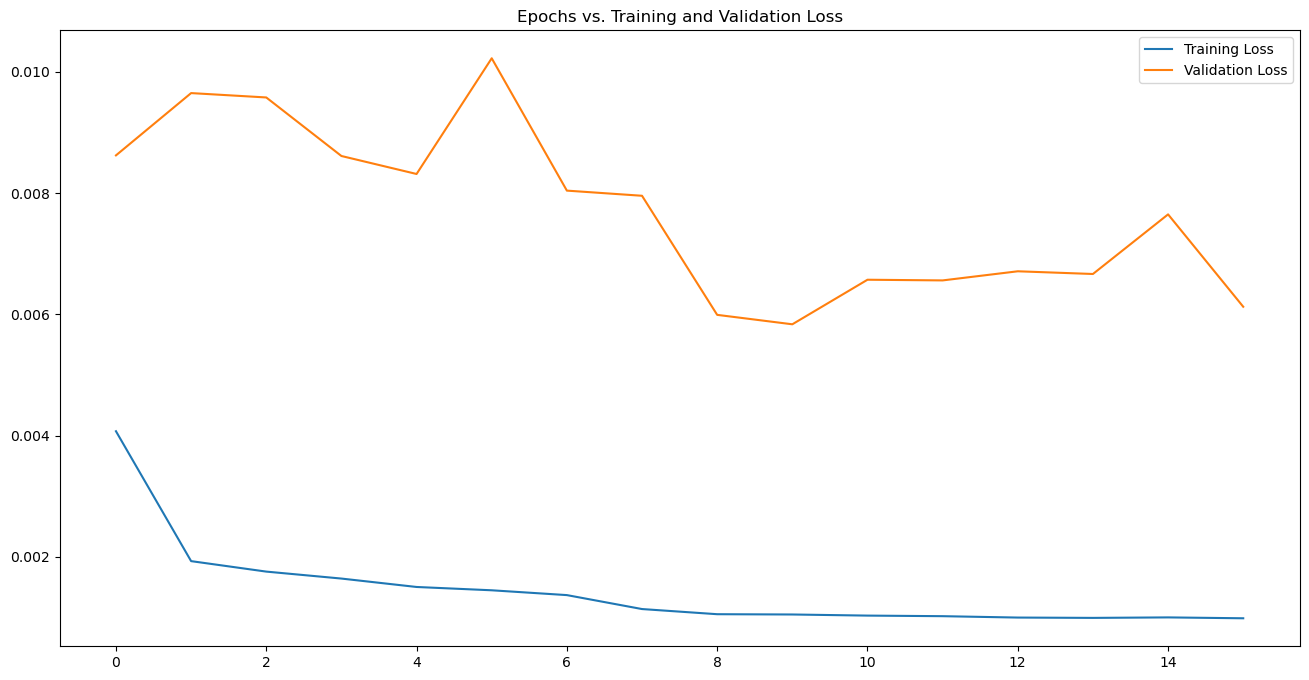

In [ ]:
plot_model_loss(univariate_history)

In [ ]:
# Valuta il modello
loss = model.evaluate(X_test, y_test)
print(f'Errore quadratico medio: {loss}')

# Fai previsioni per il test set
forecast = model.predict(X_test)

# Denormalizza le previsioni
uni_lstm_forecast = scaler.inverse_transform(forecast)



313/313 [==============================] - 16s 51ms/step - loss: 0.0026
Errore quadratico medio: 0.002574956277385354
313/313 [==============================] - 16s 50ms/step


In [ ]:
y_test_inv_uni = y_sc.inverse_transform(y_test.squeeze(-1))
# y_test_inv_uni = scaler.inverse_transform(y_test)

In [ ]:
# forflat = uni_lstm_forecast.flatten()

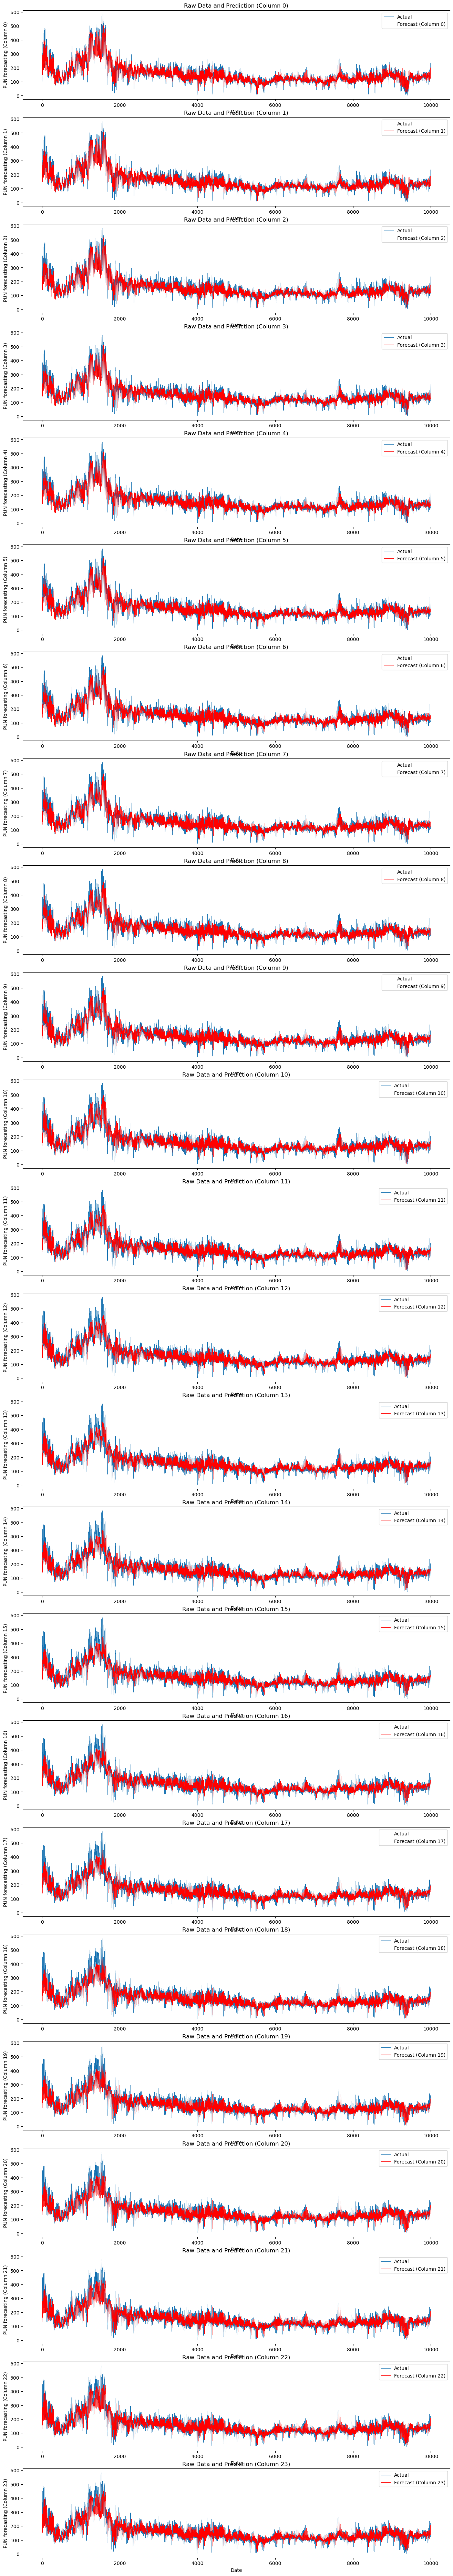

In [ ]:
uni_table = evaluate_and_plot_timeseries(y_test_inv_uni, uni_lstm_forecast, show_plot=True)

Min NMAE: 0.094 for Column: 0.0
Min RMSE: 19.822 for Column: 0.0
Min MAPE: 12.263 for Column: 0.0


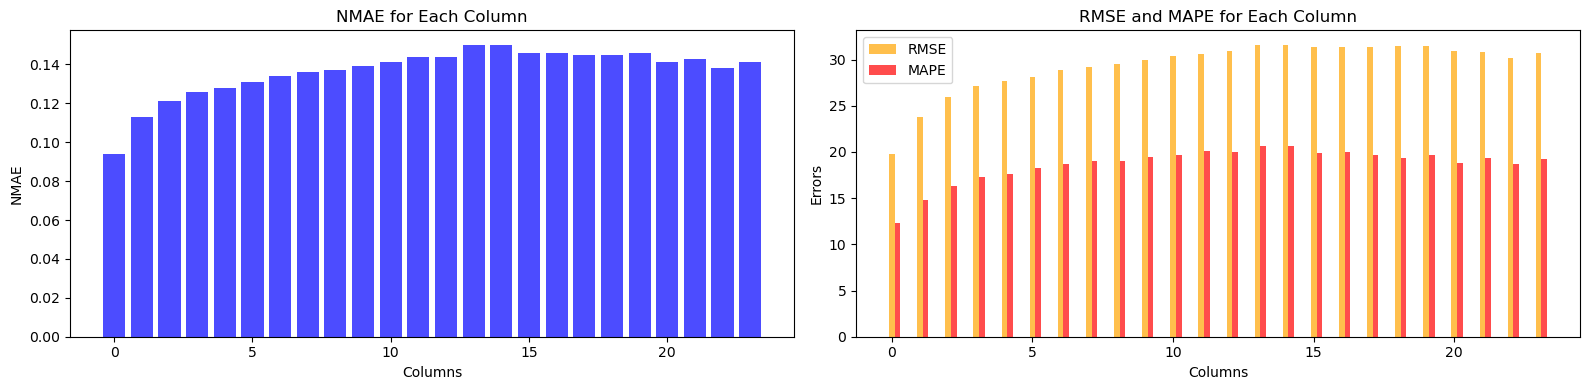

In [ ]:
plot_error_metrics_barchart(uni_table)

### Multivariate

In [ ]:
tf.keras.backend.clear_session()
multivariate_lstm = tf.keras.Sequential()

# multivariate_lstm.add(LSTM(200, input_shape=input_shape, return_sequences=True)) 
# multivariate_lstm.add(Dropout(0.2))

multivariate_lstm.add(LSTM(100, input_shape=input_shape)) 
multivariate_lstm.add(Dropout(0.2))


# multivariate_lstm.add(Activation(custom_activation,name = "Swish"))
# multivariate_lstm.add(Dense(100))
multivariate_lstm.add(Dense(target_size))



multivariate_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
Total params: 45224 (176.66 KB)
Trainable params: 45224 (176.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
221/221 [==============================] - 9s 27ms/step - loss: 0.0767 - root_mean_squared_error: 0.2770 - val_loss: 0.1111 - val_root_mean_squared_error: 0.3333 - lr: 1.0000e-05
Epoch 2/50
221/221 [==============================] - 7s 32ms/step - loss: 0.0517 - root_mean_squared_error: 0.2275 - val_loss: 0.0674 - val_root_mean_squared_error: 0.2597 - lr: 1.1220e-05
Epoch 3/50
221/221 [==============================] - 6s 27ms/step - loss: 0.0335 - root_mean_squared_error: 0.1830 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1982 - lr: 1.2589e-05
Epoch 4/50
221/221 [==============================] - 5s 23ms/step - loss: 0.0253 - root_mean_squared_error: 0.1592 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1661 - lr: 1.4125e-05
Epoch 5/50
221/221 [==============================] - 5s 24ms/step - loss: 0.0188 - root_mean_squared_error: 0.1373 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1241 - lr: 1.5849e-05
Epoch 6/50
221/221 [==============================

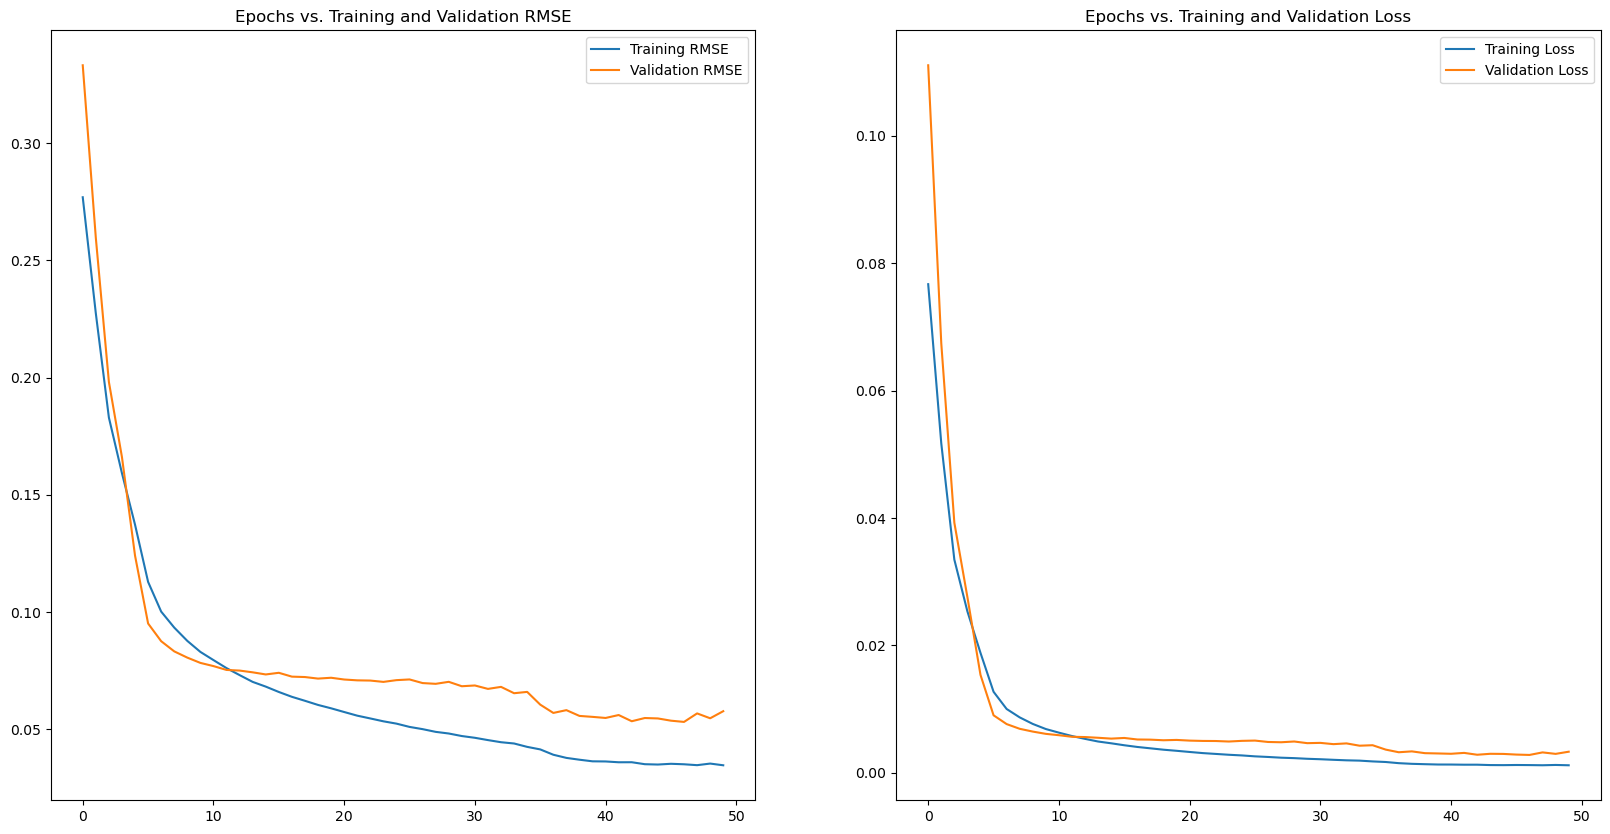

In [ ]:
# Callback per il salvataggio del modello
# lstm_checkpoint = ModelCheckpoint('multivariate_lstm_df_gas.h5', monitor='val_loss', save_best_only=True)

multivariate_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 
# multivariate_lstm.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(1e-8, momentum=0.9) , metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

# Vuole questa metrica altrimenti fa capricci con la stringa
# y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]), 1)


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-5 * 10**(epoch/20))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0002, restore_best_weights=True)

In [ ]:

history = multivariate_lstm.fit(X_train, y_train, epochs=50, verbose=1,
                                validation_split=0.2, batch_size=64,
                                callbacks=[early_stopping, lr_schedule])

plot_model_rmse_and_loss(history)


In [ ]:
# multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = y_sc.inverse_transform(forecast)


235/235 [==============================] - 2s 7ms/step


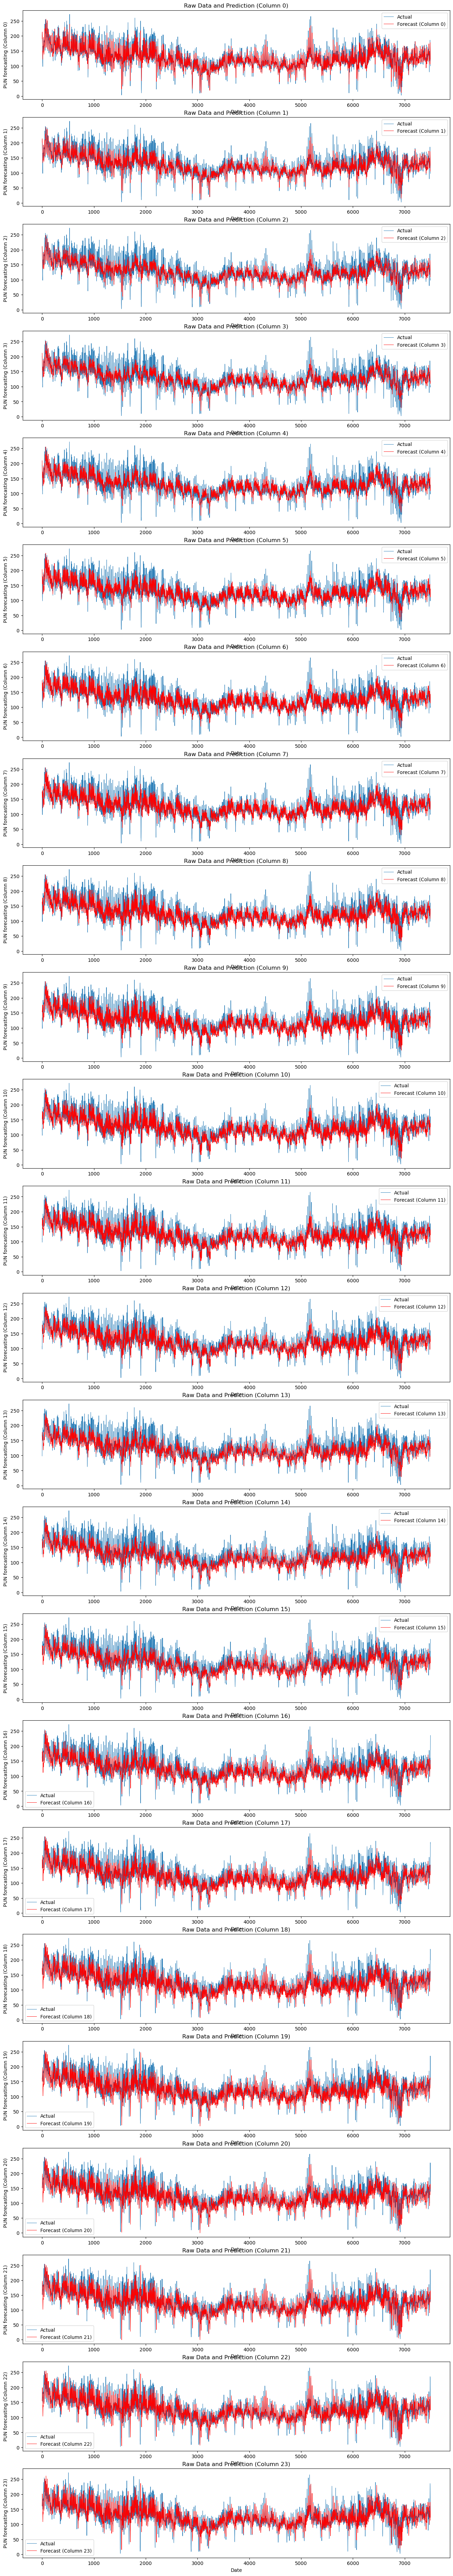

In [ ]:
lstm_table = evaluate_and_plot_timeseries(y_test_inv, lstm_forecast, show_plot=True)

Min NMAE: 0.088 for Column: 0.0
Min RMSE: 15.394 for Column: 0.0
Min MAPE: 10.46 for Column: 0.0
(0.088, 15.394, 10.46)


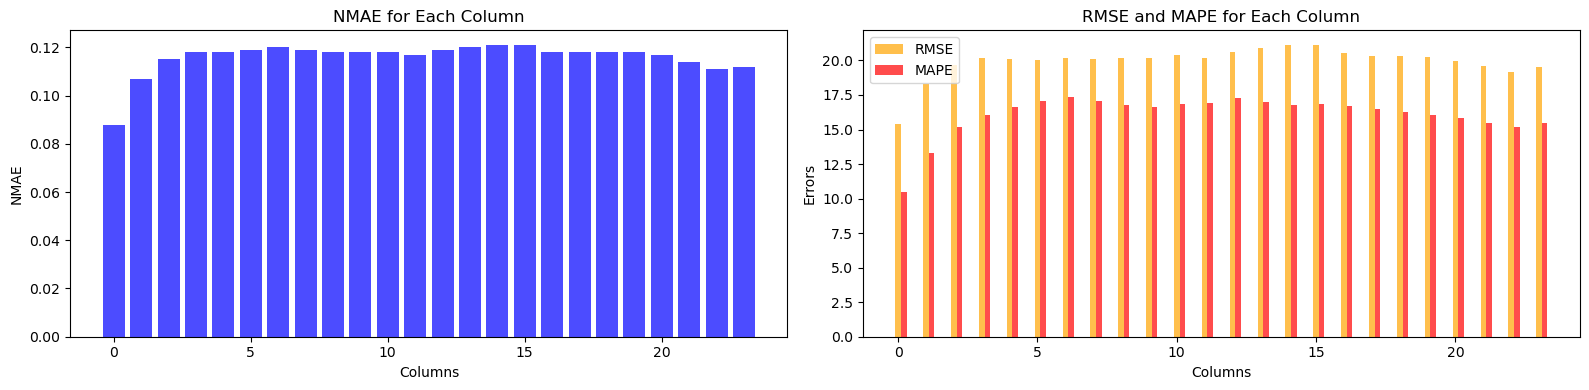

In [ ]:
plot_error_metrics_barchart(lstm_table)


### Hyperparameters search

In [52]:
# Define the model function
def build_model(hp):
  model = tf.keras.Sequential()
  # Choose the number of LSTM layers between 1 and 3
  for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
    # Choose the number of LSTM units between 50 and 200
    # Check the value of num_layers to set return_sequences
    if hp.get('num_layers') == 1:
      model.add(LSTM(hp.Int('units_' + str(i), min_value=50, max_value=200, step=50), input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    else:
      model.add(LSTM(hp.Int('units_' + str(i), min_value=50, max_value=200, step=50), input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    # Choose the dropout between 0 and 0.5
    model.add(Dropout(hp.Float('dropout_' + str(i), min_value=0, max_value=0.5, step=0.1)))
  # Add the output layer with one neuron for each hour to predict
  model.add(Dense(y_train.shape[1]))
  # Compile the model using adam as optimizer and mean_squared_error as loss function
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

In [54]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0002, restore_best_weights=True)

tuner = kt.BayesianOptimization(build_model, objective='val_loss', max_trials=10, 
                                num_initial_points=2, beta=2.6, project_name='LSTM_tuning_multivariate')

tuner.search(X_train, y_train, epochs=40, batch_size=64, validation_split=0.2, callbacks = [early_stopping], verbose=2)
best_model = tuner.get_best_models()[0]

Trial 3 Complete [00h 00m 02s]

Best val_loss So Far: 0.008615099824965
Total elapsed time: 00h 01m 18s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
3                 |1                 |num_layers
150               |100               |units_0
0.2               |0.2               |dropout_0
150               |None              |units_1
0.1               |None              |dropout_1
50                |None              |units_2
0.3               |None              |dropout_2

Epoch 1/40


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    

RuntimeError: Number of consecutive failures excceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_file0l4304jv.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 1608, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 24 and 64 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential/dense/BiasAdd, IteratorGetNext:1)' with input shapes: [64,24,24], [64,24].



In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
# Print the values of each hyperparameter
print("Best number of layers:", best_hps.get("num_layers"))
print("Best number of units for layer 0:", best_hps.get("units_0"))
print("Best dropout for layer 0:", best_hps.get("dropout_0"))
# Repeat for the other layers if num_layers > 1


In [ ]:
tuned_forecast = best_model.predict(X_test)

# Denormalizza le previsioni
tuned_uni_lstm_forecast = y_sc.inverse_transform(tuned_forecast)

In [ ]:
y_test_inv_uni = y_sc.inverse_transform(y_test.squeeze(-1))

In [ ]:
null_indices = np.where(y_test_inv_uni[:,0] == 0)

In [ ]:
y_test_inv_uni[null_indices, 0] = 5

In [ ]:
# y_test_inv_uni = scaler.inverse_transform(y_test)
uni_table = evaluate_and_plot_timeseries(y_test_inv_uni, tuned_uni_lstm_forecast, show_plot=True)

In [ ]:
plot_error_metrics_barchart(uni_table)